In [18]:
import datetime
import os
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -- pandas optional setting for dataframe appearence
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

%matplotlib inline

In [11]:
!ls -l ../txt/ | grep tweets

-rw-r--r--  1 DaiOnishi  staff  41120 Jan  1 21:14 dict_tweets_012114.pickle
-rw-r--r--  1 DaiOnishi  staff  71276 Jan  1 21:39 dict_tweets_012139.pickle
-rw-r--r--  1 DaiOnishi  staff   8474 Jan  1 09:39 tweets_by_performer_0939.tsv


## read pickle file

In [28]:
filename = [
    'dict_tweets_012139.pickle',
][0]
with open (os.path.join('..', 'txt', filename), 'rb') as f:
    dict_tweets = pickle.load(f)
'''
dict_tweets : dictionary of 'all tweets related to the performer' for all performers

dict_tweets[performer]
    tweet_time : pandas._libs.tslibs.timestamps.Timestamp (datetime64[ns, Asia/Tokyo])
    tweets_text : str
'''

# -- round timestamp by minute
for performer in dict_tweets.keys():
    dict_tweets[performer]['tweet_time'] = dict_tweets[performer]['tweet_time'].apply(lambda x: x.round(freq='min'))

dict_tweets['坂本冬美']
# dict_tweets['坂本冬美']['tweet_time'].iloc[0]
#dict_tweets['坂本冬美']['tweet_time'].iloc[0].to_pydatetime().strftime('%Y %m %d %H %M')

,tweet_time,tweet_text
0,2018-12-31 23:31:00+09:00,坂本冬美さんは\n「明日へと」\n歌ってほしかったなぁ。\n＃坂本冬美\n＃ウインズ平阪 https://t.co/bl0qqZqXQh
1,2018-12-31 23:30:00+09:00,坂本冬美さんがトップバッターだったのが今夜の盛り上がりスタート！\nさすが冬美さん！\n\n#夜桜お七 \n#紅白歌合戦2018 \n#坂本冬美
2,2018-12-31 23:19:00+09:00,#紅白歌合戦\n結局トップの夜桜お七と\nトリの天城越えが一番良かった\nってのはちょっとビミョー☺️\n#石川さゆり #坂本冬美
3,2018-12-31 23:08:00+09:00,小春ちゃん！！\nさっきるーさんも坂本冬美さんの曲の振付に名前出てた。毎週見てたチャンプル。改めてすごい番組見てたんだなぁ⋯\n#紅白 #紅白歌合戦\n#菅原小春 #RUU\n#米津玄師 #坂本冬美
4,2018-12-31 22:38:00+09:00,アメブロを更新しました。 『歌姫の紅白歌合戦』 #坂本冬美 #紅白歌合戦\nhttps://t.co/fMLVPKuzC7


## draw barplot

In [4]:
df_cnt = pd.DataFrame(
    [[performer, dict_tweets[performer].shape[0]] for performer in dict_tweets.keys()],
    columns=['performer', 'cnt_tweets'])

df_cnt.head()

,performer,cnt_tweets
0,三代目 J Soul Brothers,5
1,坂本冬美,5
2,郷ひろみ,5
3,Little Glee Monster,5
4,山内惠介,5


Text(0, 0.5, '歌手名')

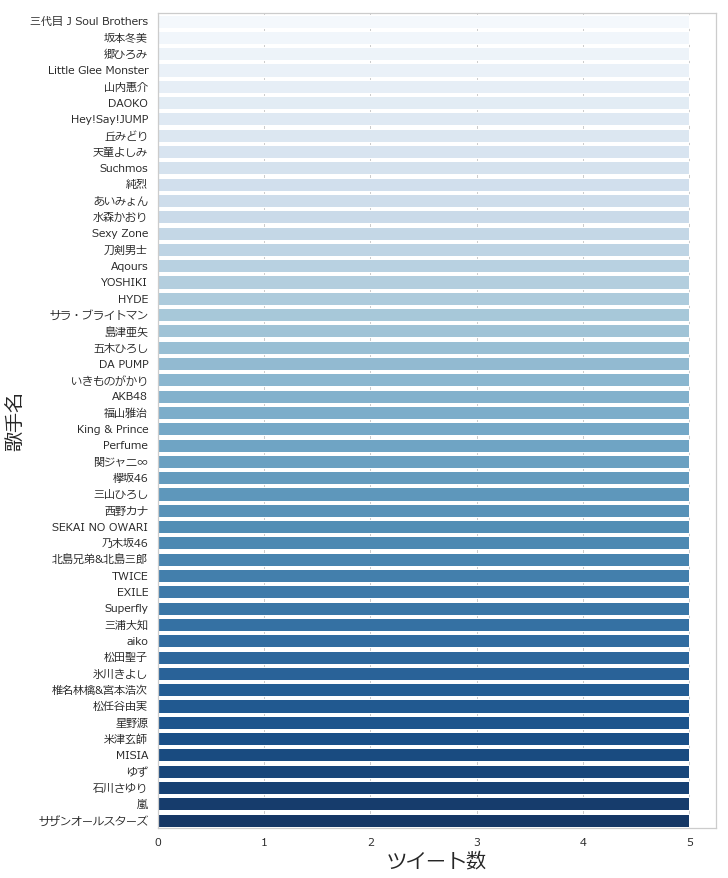

In [5]:
sns.set(style='whitegrid', font='Meiryo', rc = {'figure.figsize': (10, 15)}, )
ax = sns.barplot(x='cnt_tweets', y='performer', data=df_cnt, palette='Blues')
ax.set_xlabel('ツイート数', fontsize=20)
ax.set_ylabel('歌手名', fontsize=20)

## draw lineplot
* notes
    - data_rangeで用意した時間軸(x軸)に各出演者の値をLEFT OUTER JOINしている
    - resample, asfreq: time seriesの始点と終点を指定できない
        - resampleは時刻を切り下げているようだ。一方でroundは最も近い時刻に寄せているようだ。

In [61]:
left = pd.DataFrame({'tweet_time': pd.date_range(start='2018-12-31 19:15:00', end='2018-12-31 23:44:59', freq='5min', tz='Asia/Tokyo')})
df_timeseries = pd.DataFrame(columns=['tweet_time', 'performer', 'cnt_tweets'], index=None)

for performer in dict_tweets.keys():
    # -- count tweets by minute
    right = dict_tweets[performer].groupby(['tweet_time'], as_index=False).count().rename(columns={'tweet_text': 'cnt_tweets'})
    # -- re-count tweets by 5 minutes
    right = right.resample('5min', on='tweet_time').sum().reset_index()
    joined = left.merge(right=right, how='left', on='tweet_time', suffixes=['', '']).fillna(0)  # (?) if use inplace=True in fillna(), nothing returned
    joined['performer'] = performer
    df_timeseries = pd.concat([
        df_timeseries,
        joined
    ], sort=True)
# -- 以下の1行でtimestamp -> strに変換できるが、それをするとグラフのメモリが汚くなる
#df_timeseries['tweet_time'] = df_timeseries['tweet_time'].dt.strftime('%H%M')

df_timeseries.head()

,cnt_tweets,performer,tweet_time
0,0.0,三代目 J Soul Brothers,2018-12-31 19:15:00+09:00
1,0.0,三代目 J Soul Brothers,2018-12-31 19:20:00+09:00
2,0.0,三代目 J Soul Brothers,2018-12-31 19:25:00+09:00
3,0.0,三代目 J Soul Brothers,2018-12-31 19:30:00+09:00
4,0.0,三代目 J Soul Brothers,2018-12-31 19:35:00+09:00


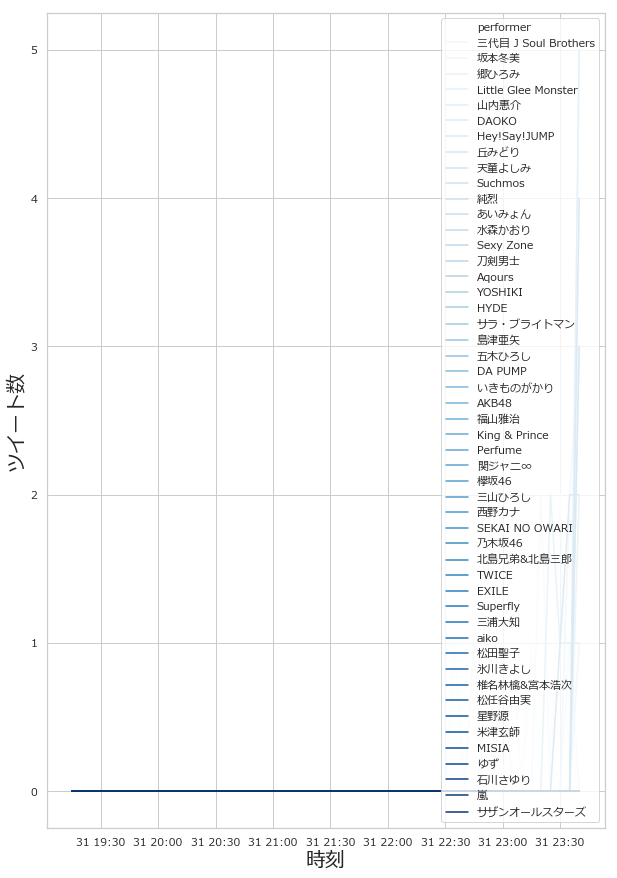

In [64]:
sns.set(style='whitegrid', font='Meiryo', rc = {'figure.figsize': (10, 15)}, )
ax = sns.lineplot(x='tweet_time', y='cnt_tweets', hue='performer', data=df_timeseries, palette="Blues")
ax.set_xlabel('時刻', fontsize=20)
ax.set_ylabel('ツイート数', fontsize=20)
ax.xaxis_date(tz='Asia/Tokyo')  # treat x-axis timestamp as if you are in tz='Asia/Tokyo'

## old

In [39]:
df_timeseries = pd.DataFrame({'tweet_time': pd.date_range(start='2018-12-31 19:15:00', end='2018-12-31 23:44:59', freq='5min', tz='Asia/Tokyo')})

for performer in dict_tweets.keys():
    # -- count tweets by minute
    right = dict_tweets[performer].groupby(['tweet_time'], as_index=False).count().rename(columns={'tweet_text': performer})
    # -- re-count tweets by 5 minutes
    right = right.resample('5min', on='tweet_time').sum().reset_index()
    df_timeseries = df_timeseries.merge(right=right, how='left', on='tweet_time', suffixes=['', ''])
df_timeseries.fillna(0, inplace=True)

df_timeseries.head()

,tweet_time,三代目 J Soul Brothers,坂本冬美,郷ひろみ,Little Glee Monster,山内惠介,DAOKO,Hey!Say!JUMP,丘みどり,天童よしみ,Suchmos,純烈,あいみょん,水森かおり,Sexy Zone,刀剣男士,Aqours,YOSHIKI,HYDE,サラ・ブライトマン,島津亜矢,五木ひろし,DA PUMP,いきものがかり,AKB48,福山雅治,King & Prince,Perfume,関ジャニ∞,欅坂46,三山ひろし,西野カナ,SEKAI NO OWARI,乃木坂46,北島兄弟&北島三郎,TWICE,EXILE,Superfly,三浦大知,aiko,松田聖子,氷川きよし,椎名林檎&宮本浩次,松任谷由実,星野源,米津玄師,MISIA,ゆず,石川さゆり,嵐,サザンオールスターズ
0,2018-12-31 19:15:00+09:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-12-31 19:20:00+09:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-12-31 19:25:00+09:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-12-31 19:30:00+09:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-12-31 19:35:00+09:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 0, 'test')

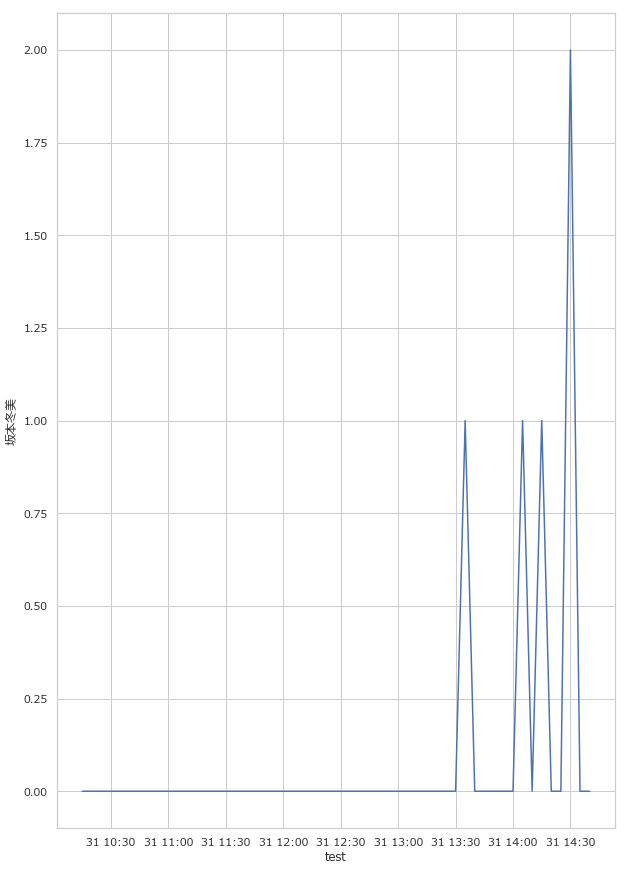

In [40]:
sns.set(style='whitegrid', font='Meiryo', rc = {'figure.figsize': (10, 15)}, )
ax = sns.lineplot(x='tweet_time', y='坂本冬美', data=df_timeseries, legend='brief')
ax.set_xlabel('test')

## playground

In [ ]:
## list up available font
import matplotlib.font_manager
l = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

l

In [ ]:
d = {}
d = {'test':1}
d['test2'] = 2
d

## sample

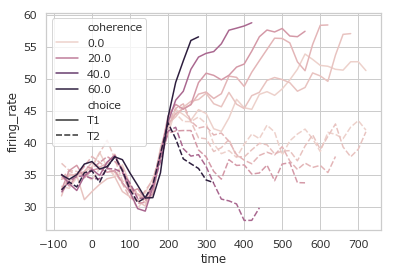

In [20]:
dots = sns.load_dataset("dots").query("align == 'dots'")
ax = sns.lineplot(x="time", y="firing_rate",hue="coherence", style="choice",data=dots)

In [21]:
dots

,align,choice,time,coherence,firing_rate
0,dots,T1,-80,0.0,33.189967
1,dots,T1,-80,3.2,31.691726
2,dots,T1,-80,6.4,34.279840
3,dots,T1,-80,12.8,32.631874
4,dots,T1,-80,25.6,35.060487
5,dots,T1,-80,51.2,34.987571
6,dots,T1,-60,0.0,32.868526
7,dots,T1,-60,3.2,35.119048
8,dots,T1,-60,6.4,34.841076
9,dots,T1,-60,12.8,35.648148
